In [1]:
from indexing import Indexer, IndexType
from document_preprocessor import RegexTokenizer
from ranker import *
from tqdm.auto import tqdm
import json
from collections import Counter, defaultdict
from network_features import NetworkFeatures
from l2r import L2RFeatureExtractor, L2RRanker
import gzip

/Users/haoyang/miniconda3/envs/si650/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# NOTE: If you want to reload a class/method without restarting the whole notebook, use/modify this
#       code to get the latest changes from your file.  You should change it to whatever file/class
#       you want reloaded. The example is for the l2r file but you can use whatever you want.
from importlib import reload
import l2r
reload(l2r)
from l2r import L2RRanker, L2RFeatureExtractor, LambdaMART

### Loading part

In [3]:
# Load in the stopwords

stopwords = set()
with open('stopwords.txt', 'r') as f:
    stopwords = set(map(lambda x: x.strip(), f.readlines()))
print('Loaded %d stopwords' % len(stopwords))

Loaded 543 stopwords


In [4]:
# from indexing import read_dataset
# docid_to_category = {}
# dataset_path = 'wikipedia_200k_dataset.jsonl.gz'
# for doc in tqdm(read_dataset(dataset_path), total=200000):
#     docid_to_category[doc['docid']] = set(doc['categories'])

In [5]:
# # Get or pre-compute the list of categories at least the minimum number of times (specified in the homework)
# category_counts = Counter()
# for docid, categories in docid_to_category.items():
#     category_counts.update(categories)
# recognized_categories = set()
# minimum_category_count = 1000
# for category, count in category_counts.items():
#     if count >= minimum_category_count:
#         recognized_categories.add(category)
# print("saw %d categories" % len(recognized_categories))

# # Map each document to the smallest set of categories that occur frequently
# doc_category_info = {}
# for docid, categories in docid_to_category.items():
#     doc_category_info[docid] = list(recognized_categories.intersection(categories))

# with open('doc_category_info.json', 'w') as f:
#     json.dump(doc_category_info, f)

In [6]:
doc_category_info = {}
with open('doc_category_info.json', 'r') as f:
    doc_category_info = json.load(f)
    doc_category_info = {int(k): v for k, v in doc_category_info.items()}

In [7]:
recognized_categories = set()
with open('recognized_categories.txt', 'r') as f:
    recognized_categories = set(map(lambda x: x.strip(), f.readlines()))

In [8]:
import pandas as pd
network_features = {}
# Get or load the network statistics for the Wikipedia link network
networks_stats = pd.read_csv('network_stats.csv', index_col=0)
networks_stats.head()

,docid,pagerank,authority_score,hub_score
0,12,0.000030,0.004949,0.002441
1,303,0.000049,0.008640,0.004462
2,305,0.000006,0.000564,0.000916
3,307,0.000046,0.007065,0.003142
4,308,0.000054,0.004040,0.002497


##### Q3

In [9]:
# from indexing import read_dataset

# pagerank_docids = set(networks_stats.sort_values('pagerank', ascending=False).head(10)['docid'].values)
# authority_docids = set(networks_stats.sort_values('authority_score', ascending=False).head(10)['docid'].values)
# hub_docids = set(networks_stats.sort_values('hub_score', ascending=False).head(10)['docid'].values)
# pagerank_infos = {}
# authority_infos = {}
# hub_infos = {}

# dataset_path = 'wikipedia_200k_dataset.jsonl.gz'
# for doc in tqdm(read_dataset(dataset_path), total=200000):
#     docid = doc['docid']
#     if docid in pagerank_docids:
#         mark = networks_stats['docid'] == docid
#         doc['pagerank'] = networks_stats[mark]['pagerank'].values[0]
#         pagerank_infos[docid] = doc
#     if docid in authority_docids:
#         mark = networks_stats['docid'] == docid
#         doc['authority_score'] = networks_stats[mark]['authority_score'].values[0]
#         authority_infos[docid] = doc
#     if docid in hub_docids:
#         mark = networks_stats['docid'] == docid
#         doc['hub_score'] = networks_stats[mark]['hub_score'].values[0]
#         hub_infos[docid] = doc

In [10]:
# pd.DataFrame(
#     {
#         'pagerank': list(pagerank_docids),
#         'authority_score': list(authority_docids),
#         'hub_score': list(hub_docids)
#     }
# )

In [11]:
# pd.DataFrame.from_dict(pagerank_infos, orient='index').sort_values('pagerank', ascending=False)[['docid', 'title', 'pagerank']].reset_index(drop=True)

In [12]:
# pd.DataFrame.from_dict(authority_infos, orient='index').sort_values('authority_score', ascending=False)[['docid', 'title', 'authority_score']].reset_index(drop=True)

In [13]:
# pd.DataFrame.from_dict(hub_infos, orient='index').sort_values('hub_score', ascending=False)[['docid', 'title', 'hub_score']].reset_index(drop=True)

In [14]:
for row in networks_stats.iterrows():
    network_features[row[1]['docid']] = row[1][1:].to_dict()

##### Q4

In [15]:
# from indexing import read_dataset
# q4_doc_infos = {}
# dataset_path = 'wikipedia_200k_dataset.jsonl.gz'
# for doc in tqdm(read_dataset(dataset_path, max_docs=10000), total=10000):
#     docid = doc['docid']
#     doc_length = len(doc['text'].split())
#     q4_doc_infos[docid] = {
#         'pagerank': network_features[docid]['pagerank'],
#         'doc_length': doc_length,
#     }

In [16]:
# import seaborn as sns
# import matplotlib.pyplot as plt

# # Plot article length versus PageRank using the values for the first 10K documents
# plt.loglog()
# sns.scatterplot(
#     x='doc_length',
#     y='pagerank',
#     data=pd.DataFrame.from_dict(q4_doc_infos, orient='index'),
#     alpha=0.1
# )


In [17]:
# Load or build Inverted Indices for the documents' main text and titles
#
# Estiamted times: 
#    Document text token counting: 3m40s
#    Document text indexing: 4m45s
#    Title text indexing: 22s
from time import time

preprocessor = RegexTokenizer('\w+')
print('Loading document text index...')
t0 = time()
document_indexer = Indexer.load_index('BasicInvertedIndex_doc')
t1 = time()
print('Done in %.2f seconds' % (t1- t0))
title_indexer = Indexer.load_index('BasicInvertedIndex_title')
t2 = time()
print('Done in %.2f seconds' % (t2- t1))

Loading document text index...


load index: 100%|██████████| 122784/122784 [00:33<00:00, 3665.71it/s] 


Done in 278.47 seconds


load index: 100%|██████████| 90877/90877 [00:00<00:00, 479605.21it/s]


Done in 0.45 seconds


In [18]:
import gc

In [19]:
# Create the feature extractor and an initial ranker for determining what to re-rank
# Use these with a L2RRanker and then train that L2RRanker model
#
# Estimated time (using 4 cores via n_jobs): 2m40s

feature_extractor = L2RFeatureExtractor(document_indexer, title_indexer, doc_category_info, preprocessor, stopwords, recognized_categories, network_features)
scorer = BM25(document_indexer)
ranker = L2RRanker(document_indexer, title_indexer, preprocessor, stopwords, scorer, feature_extractor)

gc.collect()

# Train the ranker
print('Training ranker...')
t0 = time()
training_data_filename = 'hw2_relevance.train.csv'
eval_data_filename = 'hw2_relevance.dev.csv'
ranker.train(training_data_filename)
t1 = time()
print('Done in %.2f seconds' % (t1- t0))


Training ranker...
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003572 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2640
[LightGBM] [Info] Number of data points in the train set: 9604, number of used features: 123
Done in 256.44 seconds


In [20]:
evaluation_data_filename = 'hw2_relevance.dev.csv'

In [21]:
feature_names = [
    "article_length",
    "title_length",
    "query_length",
    "tf_doc",
    "tf_idf_doc",
    "tf_title",
    "tf_idf_title",
    "BM25_doc",
    "pivoted_norm_doc",
    "pagerank",
    "hub_score",
    "authority_score",
    "weighted_unigram",
]

categories = []
for key, val in sorted(ranker.feature_extractor.category_to_id.items(), key=lambda x: x[1]):
    categories.append(key)

feature_names.extend(categories)

In [22]:
feature_importances = ranker.model.model.feature_importances_

##### Q5

<Axes: >

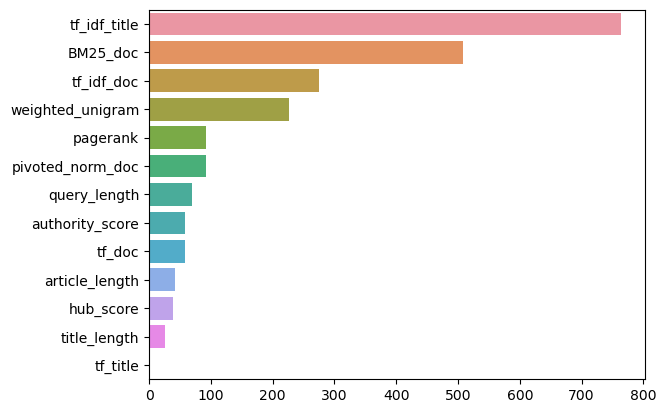

In [23]:
import matplotlib.pyplot as plt
import seaborn as sns
num_cols = 13
# Plot the feature importances with sorted features
x = ranker.model.model.feature_importances_[:num_cols]
y = feature_names[:num_cols]

x, y = zip(*sorted(zip(x, y), reverse=True))
sns.barplot(x=list(x), y=list(y))


In [24]:
non_category_feature_df = pd.DataFrame(
    {
        'feature': y,
        'importance': x
    }
)
non_category_feature_df

,feature,importance
0,tf_idf_title,764.455770
1,BM25_doc,507.411774
2,tf_idf_doc,274.577948
3,weighted_unigram,226.078532
4,pagerank,92.240010
5,pivoted_norm_doc,92.201091
6,query_length,70.105271
7,authority_score,57.673680
8,tf_doc,57.404420
9,article_length,42.369930


##### Q6

In [25]:
category_length = len(recognized_categories)
category_importance = pd.DataFrame(
    {
        'category': feature_names[-category_length:],
        'importance': ranker.model.model.feature_importances_[num_cols:]
    }
)
category_importance.sort_values('importance', ascending=False).head(5)

,category,importance
47,Category:Articles with short description,9.24552
79,Category:Articles with VIAF identifiers,8.49493
53,Category:Articles containing video clips,6.61918
92,Category:Articles with J9U identifiers,4.53467
80,Category:Articles containing Japanese-language...,4.39246


<Axes: xlabel='importance', ylabel='category'>

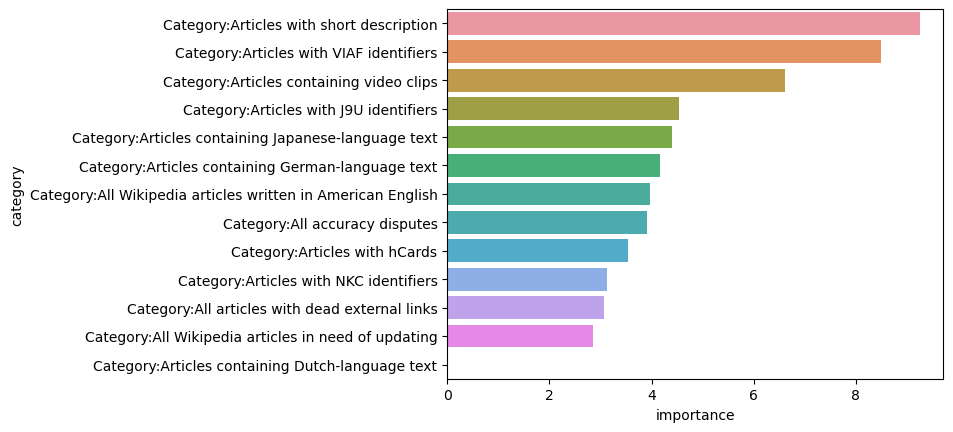

In [26]:
filter_out_zero = sum(category_importance['importance'] > 0)
sns.barplot(x='importance', y='category', data=category_importance.sort_values('importance', ascending=False).head(filter_out_zero + 1))

##### Save and Reload the model

In [26]:
ranker.model.save('l2r.model.txt')

In [27]:
# ranker.model.load('l2r_a.model.txt')

##### load the dataframe

In [27]:
import relevance
reload(relevance)
from relevance import run_relevance_tests

In [28]:
test_filename = 'hw2_relevance.test.csv'

ranker_info = run_relevance_tests(test_filename, ranker)

  0%|          | 0/37 [00:00<?, ?it/s]

100%|██████████| 37/37 [03:10<00:00,  5.14s/it]


In [29]:
base_ranker = Ranker(document_indexer, preprocessor, stopwords, scorer)
base_ranker_info = run_relevance_tests(test_filename, base_ranker)

  0%|          | 0/37 [00:00<?, ?it/s]

100%|██████████| 37/37 [01:51<00:00,  3.02s/it]


In [30]:
score_df = pd.DataFrame(
    {
        'docid': range(len(ranker_info['map_scores'])),
        'map_score': ranker_info['map_scores'],
        'base_map_score': base_ranker_info['map_scores'],
        'ndcg_score': ranker_info['ndcg_scores'],
        'base_ndcg_score': base_ranker_info['ndcg_scores'],
    }
)

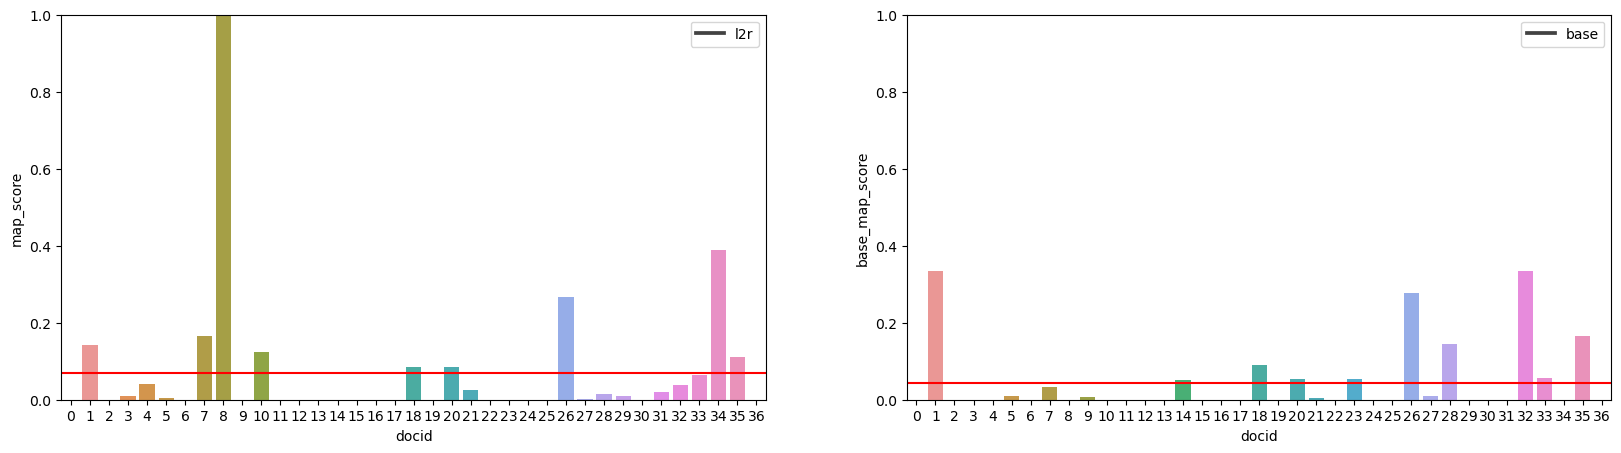

In [31]:
# plot the MAP scores for the base ranker and the L2R ranker with a mean line and confidence intervals
# make the same yscale for both plots
plt.subplots(1, 2, figsize=(20, 5))

plt.subplot(1, 2, 1)
sns.barplot(x='docid', y='map_score', data=score_df)
plt.axhline(score_df['map_score'].mean(), color='red')
plt.ylim(0, 1)
plt.legend(['l2r'])
plt.subplot(1, 2, 2)
sns.barplot(x='docid', y='base_map_score', data=score_df)
plt.axhline(score_df['base_map_score'].mean(), color='red')
plt.ylim(0, 1)
plt.legend(['base'])
plt.savefig('map_scores.png')

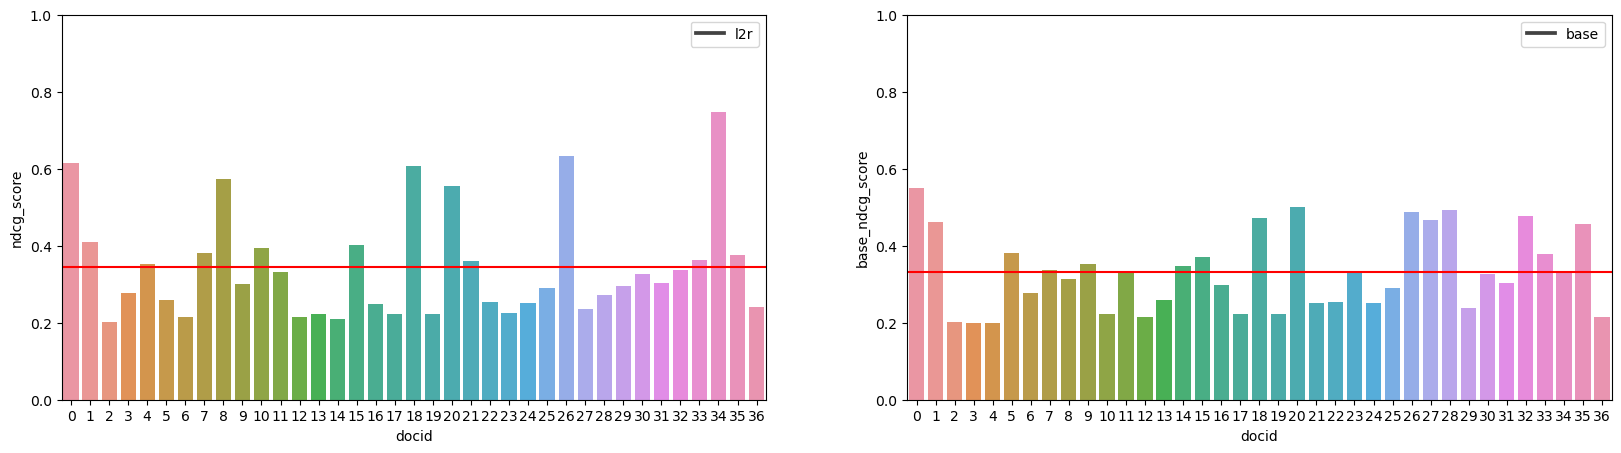

In [32]:
plt.subplots(1, 2, figsize=(20, 5))

plt.subplot(1, 2, 1)
sns.barplot(x='docid', y='ndcg_score', data=score_df)
plt.axhline(score_df['ndcg_score'].mean(), color='red')
plt.ylim(0, 1)
plt.legend(['l2r'])
plt.subplot(1, 2, 2)
sns.barplot(x='docid', y='base_ndcg_score', data=score_df)
plt.axhline(score_df['base_ndcg_score'].mean(), color='red')
plt.ylim(0, 1)
plt.legend(['base'])
plt.savefig('ndcg_scores.png')

In [33]:
ranker_info['map'], ranker_info['ndcg']

(0.07022555505643227, 0.3437513365850394)

In [34]:
base_ranker_info['map'], base_ranker_info['ndcg']

(0.04391315973201281, 0.33207116801551484)